In [3]:
# !pip install pennylane
# !pip install pennylane-qiskit

In [4]:
import pennylane as qml
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from PIL import Image

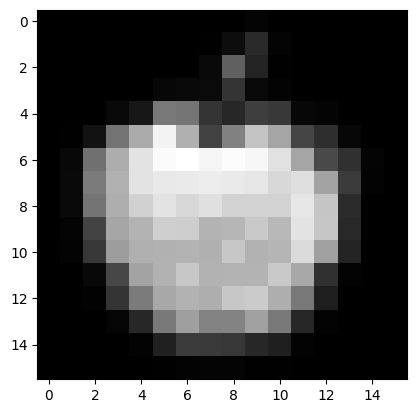

In [6]:
image = Image.open("1.png").convert('L')
# process image
input_image = image.resize((16, 16))
input_image = np.array(input_image)
input_image = (input_image - np.min(input_image))/(np.max(input_image) - np.min(input_image))

plt.imshow(input_image, cmap='gray')
input_image = np.expand_dims(input_image, axis=0)

In [156]:
# encoder = torch.nn.Sequential(
#     torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride=1, padding="valid"),
#     torch.nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, stride=1, padding="valid"),
#     torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, stride=1, padding="valid"),
#     torch.nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride=1, padding="valid"),
#     torch.nn.Conv2d(in_channels = 8, out_channels = 4, kernel_size = 3, stride=1, padding="valid"),
# )

encoder = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, stride=1, padding="valid"),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, stride=1, padding="valid"),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 5, stride=1, padding="valid"),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels = 8, out_channels = 5, kernel_size = 3, stride=1, padding="valid"),
    torch.nn.Sigmoid(),
)

encoder = encoder.double()

In [157]:
# out = encoder(torch.from_numpy(input_image))
# out.shape

In [158]:
def data_shape_transform(data, n_qubits=8):
  data = data.detach().numpy()
  data = np.reshape(data, (-1))
  out = []
  col_num = int(np.ceil(len(data)/n_qubits))
  for i in range(n_qubits):
    tmp = []
    for j in range(col_num):
      if i*col_num+j >= len(data):
        break

      tmp.append(data[i*col_num+j])

    out.append(tmp)

  return out, len(data)


In [159]:
def data_embedding(data, n_qubits=8):
  data, data_len = data_shape_transform(data, n_qubits=n_qubits)

  flag = 1
  col_num = int(np.ceil(data_len/n_qubits))
  qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")

  for j in range(col_num):
    for i in range(n_qubits):
      if i*col_num+j >= data_len:
        break

      if flag == 1:
        qml.RZ(data[i][j], wires=i)
      else:
        qml.RX(data[i][j], wires=i)

    flag *= -1


In [160]:
# def apply_weights(weights, n_qubits=8):
#   for j in range(0, len(weights[0]), 2):
#     for i in range(len(weights)):
#       qml.RY(weights[i][j], wires=i)
#       qml.RZ(weights[i][j+1], wires=i)

#     for l in range(len(weights)):
#       if (l == (len(weights) - 1)):
#         qml.CNOT(wires=[l,0])
#       else:
#         qml.CNOT(wires=[l,l+1])

def apply_weights(weights, n_qubits=8):

  for i in range(len(weights)):

    for j in range(n_qubits):
      qml.RZ(weights[i][j], wires=j)

    index = j
    flag = 1
    for k in range(n_qubits):
      for j in range(n_qubits):
        if k == j:
          continue
        index += 1
        if flag == 1:
          qml.CRX(weights[i][index], wires=[k, j])
        else:
          qml.CRY(weights[i][index], wires=[k, j])

      flag *= -1

    for j in range(n_qubits):
      qml.RZ(weights[i][index+j], wires=j)

In [161]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, X in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, X)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        #     accuracy = np.sum(np.argmax(pred.detach().numpy(), axis=-1) == y.detach().numpy())/len(y)
        #     print(f"accuracy: {accuracy}")

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()
            correct += (pred.argmax(1) == X).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n MSE: {(correct)}, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

def train(model, train_dataloader, epochs, loss_fn, optimizer):
    accuracy_hist = []
    loss_hist = []

    for epoch in range(epochs):
        train_loop(train_dataloader, model, loss_fn, optimizer)

        # after 10 epochs check the performance of the model on the training data
        if epoch % 10 == 0:
          print(f"Epoch {epoch+1}\n-------------------------------")
          loss, accuracy = test_loop(train_dataloader, model, loss_fn)
          accuracy_hist.append(accuracy)
          loss_hist.append(loss)

    print("Finish")
    return accuracy_hist, loss_hist

In [162]:
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits, shots=512)

In [163]:
@qml.qnode(dev)
def c1(inputs, weights):
  data_embedding(inputs, n_qubits=8)
  apply_weights(weights, n_qubits=8)

  return qml.probs(wires=range(n_qubits))


In [164]:
class Q1Layer(torch.nn.Module):

    def __init__(self, circuit=None, n_qubits=8, q_depth=1):
        super().__init__()
        # self.qweights = torch.nn.Parameter(torch.randn(n_qubits, 2*q_depth))
        self.qweights = torch.nn.Parameter(torch.randn(q_depth, n_qubits**2 + n_qubits))
        self.qlayer_1 = circuit

    def forward(self, input_):
        q = self.qlayer_1(input_, self.qweights)
        q = q.unsqueeze(0)
        return torch.reshape(q, (1, 16, 16))

In [165]:
autoencoder = torch.nn.Sequential(
    encoder,
    Q1Layer(circuit=c1, n_qubits=n_qubits, q_depth=2),
    torch.nn.Conv2d(in_channels = 1, out_channels = 5, kernel_size = 3, stride=1, padding="same"),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels = 5, out_channels = 1, kernel_size = 3, stride=1, padding="same"),
    torch.nn.Sigmoid(),
)

autoencoder = autoencoder.double()

In [166]:
print(input_image.shape)
out = autoencoder(torch.from_numpy(input_image))
out.shape

(1, 16, 16)


torch.Size([1, 16, 16])

In [167]:
data = pd.read_excel('prepared_dataset.xlsx')
data = pd.DataFrame(data).to_numpy()
# add more 1?
data = np.reshape(data, (len(data), 16, 16))

In [168]:
batch_size = 1

In [169]:
train_dataloader = DataLoader(torch.from_numpy(data), batch_size=batch_size)

In [170]:
lr = 0.005
epochs = 200

In [171]:
# loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.L1Loss()
# loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)

In [ ]:
accuracy_hist, loss_hist = train(autoencoder, train_dataloader, epochs, loss_fn, optimizer)

Epoch 1
-------------------------------
Test Error: 
 MSE: 85.8, Avg loss: 0.365295 



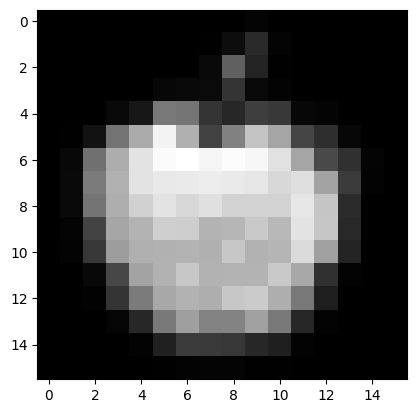

In [132]:
index = 0
plt.imshow(data[index], cmap='gray')

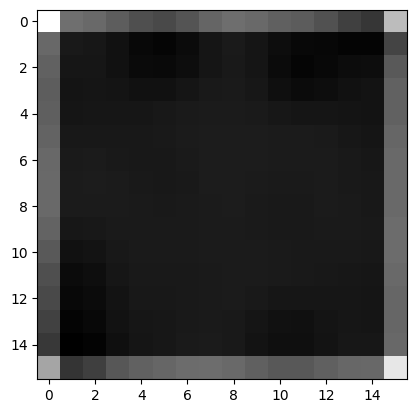

In [134]:
inp = np.expand_dims(data[index], axis=0)
out = autoencoder(torch.from_numpy(inp))
out = out.detach().numpy()
plt.imshow(out[0], cmap='gray')

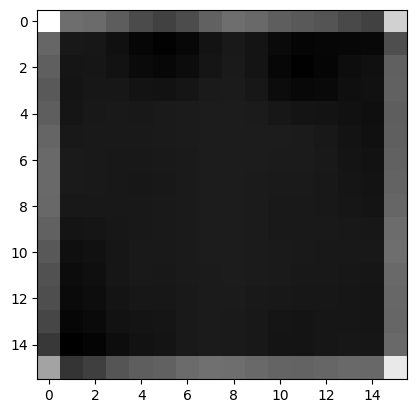

In [135]:
inp = np.expand_dims(data[2], axis=0)
out = autoencoder(torch.from_numpy(inp))
out = out.detach().numpy()
plt.imshow(out[0], cmap='gray')